shape of M is (4, 2, 2, 2720)


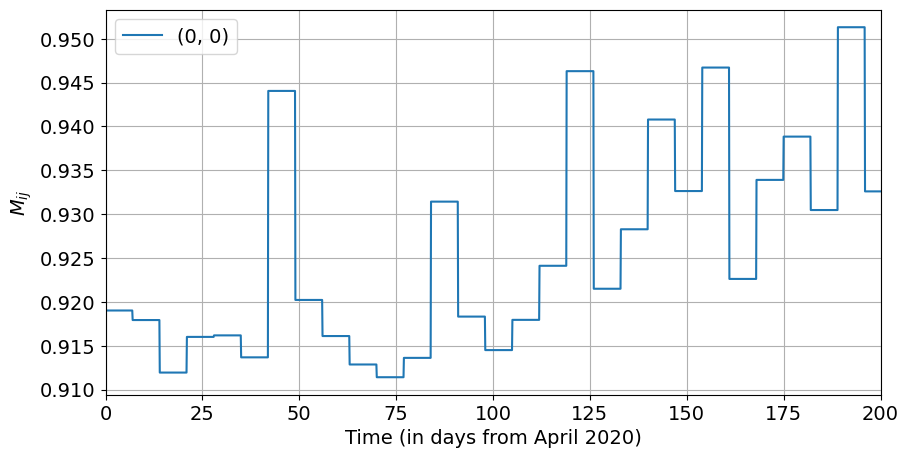

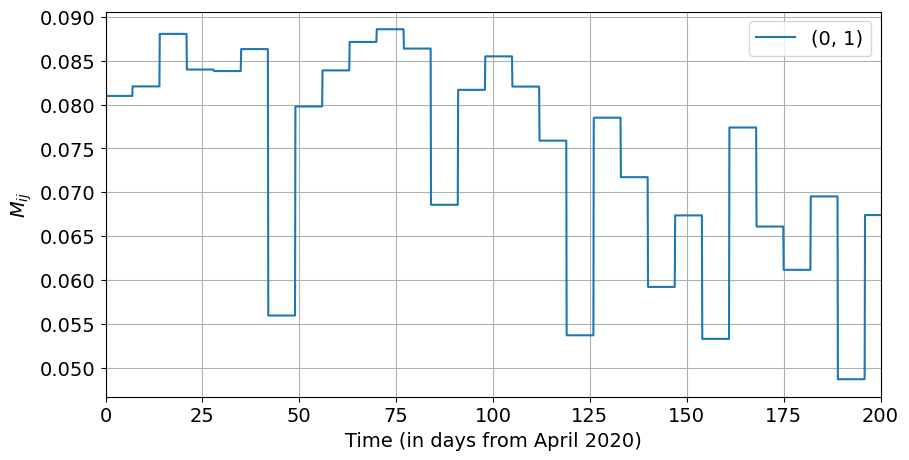

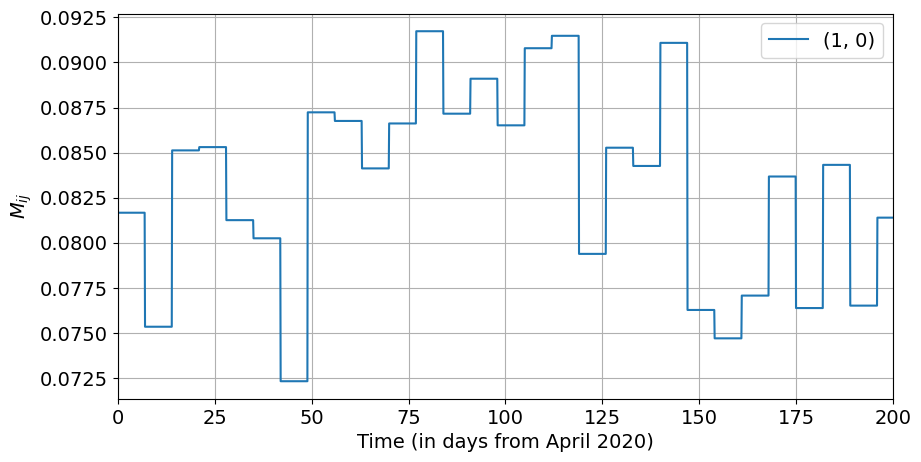

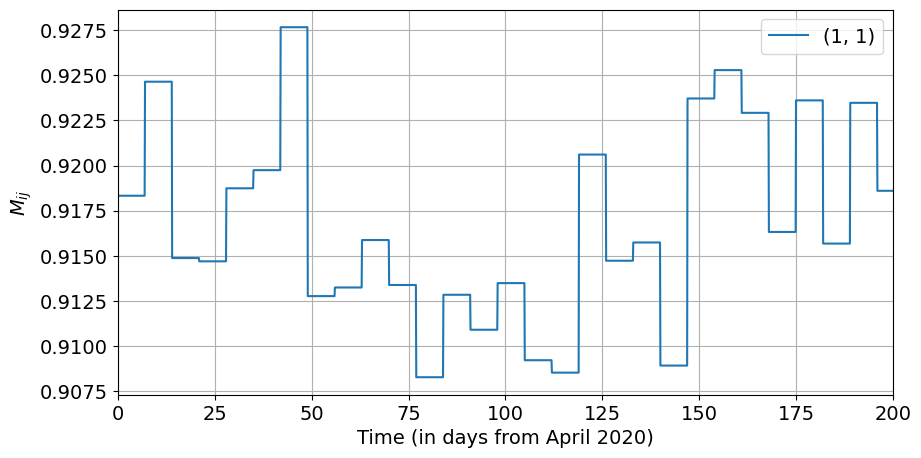

initial infected in PHU1 0.0
total population in PHU1 2794356.0


In [11]:

import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import scipy.stats as st

dt = 0.1
tstart = 0
tlim = 200
t = np.arange(tstart, tlim, 1)

d_cut = 160

ndiv = 1/dt

### keep it always starting at 0
tmoh = np.arange(0, tlim, dt)

N_city = 2

PHU_path = './../../PHU_Data/'
figpath = './../../figs/predictions/coupled_synth_160'
datapath = './../../data'
Mobility_path = '/Users/sudhipv/documents/coupled_compartment/mobility_tensor'

Data = np.zeros([365,4])

files = os.listdir(PHU_path)

target_file1 = f'{PHU_path}/30-Toronto.csv'
target_file2 = f'{PHU_path}/34-York.csv'
target_file3 = f'{PHU_path}/04-Durham.csv'
target_file4 = f'{PHU_path}/22-PeelRegion.csv'
# target_file5 = f'{datapath}/toronto_synthetic_data_noise10.csv'

target_file5 = f'{datapath}/coupled_synth_data_r100.csv'

Data[:,0] = np.genfromtxt(target_file1, delimiter=',')
Data[:,1] = np.genfromtxt(target_file2, delimiter=',')
Data[:,2] = np.genfromtxt(target_file3, delimiter=',')
Data[:,3] = np.genfromtxt(target_file4, delimiter=',')


population_by_phu = np.genfromtxt(f'{PHU_path}/population_by_phu.csv', delimiter=',')


#### CHANgE HERE ########
x_data = np.genfromtxt(target_file5, delimiter=',')



# x_data1 = Data[:,0]
# x_data2 = Data[:,2]
t_data = np.arange(0,tlim)


# Preallocate compartments
S = np.zeros((len(tmoh),N_city))
E = np.zeros((len(tmoh),N_city))
I = np.zeros((len(tmoh),N_city))
R = np.zeros((len(tmoh),N_city))
D = np.zeros((len(tmoh),N_city))
N = np.zeros((len(tmoh),N_city))


# For noisy synthetic model output
I_model = np.zeros((len(t),N_city))
I_synthetic = np.zeros((len(t),N_city))


# Stratification Tensor M
M = np.zeros((4,N_city,N_city,2720))

print("shape of M is", np.shape(M))


#####################################################################################


#  Below part of code is not well written - It uses the weekly data to generate the daily values 
# of mobility tensor and further saves in each time step. 

# Load the Mobility tensor values based on the Flow matrix

# Week number 13 (starting from 0) is April 6th.
# Week number 37 is Sep 21st.


Mtensor = np.zeros([52,2,2])

directory_path = f'{Mobility_path}/stochastic_Tor_Durham'
filesmobility = os.listdir(directory_path)

for ii in range(52):
    
      target_name_part = "Stochastic_matrix"+str(ii)+".dat"
    
      for file in filesmobility:
            if target_name_part == file:
              target_file = file
              break
      else:
        raise FileNotFoundError(f"Could not find any file containing '{target_name_part}'.")

      Mtensor[ii,:,:] = np.genfromtxt(f'{directory_path}/{target_file}', delimiter=' ')


### HARD CODED
mrange = int((272-0)/7) + 1


for w in range(mrange): # 39
   
    sw = 7*w
    
    if(w != mrange-1):
        tsw = np.linspace(sw, sw+6, int((1/dt)*6+1))
    else:
        tsw = np.linspace(sw, sw+5, int((1/dt)*5+1))


    for swk in range(len(tsw)):
        mindex = int((1/dt) * sw + swk)
        M[0,:,:,mindex] = Mtensor[13+w,0:N_city,0:N_city]
        M[1,:,:,mindex] = Mtensor[13+w,0:N_city,0:N_city]
        M[2,:,:,mindex] = Mtensor[13+w,0:N_city,0:N_city]
        M[3,:,:,mindex] = Mtensor[13+w,0:N_city,0:N_city]
        

    tsw2 = np.linspace(sw+6+dt, sw+7, int((1/dt)*1))
    for swk2 in range(1,len(tsw2)):
        mindex2 = mindex + swk2
        M[0,:,:,mindex2] = Mtensor[13+w,0:N_city,0:N_city]
        M[1,:,:,mindex2] = Mtensor[13+w,0:N_city,0:N_city]
        M[2,:,:,mindex2] = Mtensor[13+w,0:N_city,0:N_city]
        M[3,:,:,mindex2] = Mtensor[13+w,0:N_city,0:N_city]


mpl.rcParams.update({'font.size':14})
for i in range(N_city):
    for j in range(N_city):
        plt.figure(i+j+10,figsize=(10,5))
        plt.plot(tmoh, M[0,i,j,0:len(tmoh)], label=f'{i,j}')
        plt.legend(loc='best')
        plt.xlabel('Time (in days from April 2020)')
        plt.xlim([0,tlim])
        plt.ylabel('$M_{ij}$')
        plt.grid()
        plt.show()


#####################################################################################

#####Force of infection , Lambda
L_Force = np.zeros((len(tmoh),N_city))
 
total = np.zeros((N_city))

 ####### CHANGE HERE ######################
total[0] = population_by_phu[29,1]
total[1] = population_by_phu[3,1]
 #####################################


# Model parameters - Taken from Southern Ontario - COVID MBE paper
gamma_e = 1/15
gamma_i = 1/5
gamma_r = 1/11
gamma_d = 1/750

beta_e = np.zeros((len(tmoh),N_city)) 
beta_i = np.zeros((len(tmoh),N_city))

beta_calibrated = np.zeros((len(tmoh),N_city))


print("initial infected in PHU1",I[0,0])

print("total population in PHU1",total[0])

#### PEEL - 234 , 1451022

#### Toronto - 430 , 2794356

### York - 212, 1173334

### Durham - 94   - 696992


In [12]:

# True data

sample_path = datapath

true_path1  =  f'{datapath}/coupled_toronto_synthetic_truth_all.csv'
true_path2  =  f'{datapath}/coupled_durham_synthetic_truth_all.csv'

beta_true_path  = f'{datapath}/coupled_true_synthetic_beta.csv'

all_truth0 = np.genfromtxt(true_path1, delimiter=',')
all_truth1 = np.genfromtxt(true_path2, delimiter=',')

beta_truth = np.loadtxt(beta_true_path,delimiter=',')


S_mean = np.zeros((len(tmoh),N_city))
E_mean = np.zeros((len(tmoh),N_city))
I_mean = np.zeros((len(tmoh),N_city))
R_mean = np.zeros((len(tmoh),N_city))
D_mean = np.zeros((len(tmoh),N_city))
beta_mean = np.zeros((len(tmoh),N_city))


samples = np.loadtxt(f'{sample_path}/muVec_coupled_synth_160.dat')

# samples = np.loadtxt(f'{sample_path}/muVec_real_case2.dat')

print(samples.shape)

Nsamples = len(samples[0,:])

# I_pdf = np.zeros((tlim-d_cut,Nsamples))


for ns in range(Nsamples):


    ### Toronto
    # Initial Conditions
    ####### CHANGE HERE ######################
    E[0,0] = samples[0,ns]
    I[0,0] = samples[1,ns]
    #####################################

    R[0,0] = 0
    D[0,0] = 0
    N[0,0] = total[0]
    S[0,0] = N[0,0] - E[0,0] - I[0,0] - R[0,0] - D[0,0]

    a0 = samples[2,ns]
    a1 = samples[3,ns]
    t1 =  20
    a2 = samples[4,ns]
    t2 =  35
    a3 =  samples[5,ns]
    t3 = 60
    a4 =  samples[6,ns]
    t4 = 80
    a5 =  samples[7,ns]
    t5 =  140
    # a6 =  samples[8,ns]
    # t6 = 180
    # a7 =  samples[9,ns]
    # t7 =  190


    beta_i[:,0] = a0  + a1/(1 + np.exp((t1-tmoh))) +  a2/(1 + np.exp((t2-tmoh)))  + a3/(1 + np.exp((t3-tmoh)))  + a4/(1 + np.exp((t4-tmoh)))  + a5/(1 + np.exp((t5-tmoh))) \
        #   + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) 
    # + a8/(1 + np.exp((t8-tmoh)))

    beta_mean[:,0] = beta_mean[:,0] + beta_i[:,0]

    beta_e[:,0] = beta_i[:,0]


    ##############################################################################################################    #####################################    #####################################

    ### Durham
    # Initial Conditions
    ####### CHANGE HERE ######################
    E[0,1] = samples[8,ns]
    I[0,1] = samples[9,ns]
    #####################################

    R[0,1] = 0
    D[0,1] = 0
    N[0,1] = total[1]
    S[0,1] = N[0,1] - E[0,1] - I[0,1] - R[0,1] - D[0,1]

    a0 = samples[10,ns]
    a1 = samples[11,ns]
    t1 =  20
    a2 = samples[12,ns]
    t2 =  35
    a3 =  samples[13,ns]
    t3 = 65
    a4 =  samples[14,ns]
    t4 = 90
    a5 =  samples[15,ns]
    t5 =  140
    # a6 =  samples[18,ns]
    # t6 = 180
    # a7 =  samples[19,ns]
    # t7 =  190


    beta_i[:,1] = a0  + a1/(1 + np.exp((t1-tmoh))) +  a2/(1 + np.exp((t2-tmoh)))  + a3/(1 + np.exp((t3-tmoh)))  + a4/(1 + np.exp((t4-tmoh)))  + a5/(1 + np.exp((t5-tmoh))) \
        #   + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) 
    # + a8/(1 + np.exp((t8-tmoh)))

    beta_e[:,1] = beta_i[:,1]

    beta_mean[:,1] = beta_mean[:,1] + beta_i[:,1]



    ###################################################################################################################################################    #####################################


    idxmoh = 0

    for kk in range(1,len(tmoh)):

        for gg in range(0,N_city):

            L_sum = 0
            for ll in range(0,N_city):

                Nlm = 0
                L_cityinf = 0

                for mm in range(0,N_city):
                    Nlm =  Nlm + M[0,mm,ll,kk-1] * S[kk-1,mm] +  M[1,mm,ll,kk-1] * E[kk-1,mm] + M[2,mm,ll,kk-1] * I[kk-1,mm] + M[3,mm,ll,kk-1] * R[kk-1,mm]

                    L_cityinf = L_cityinf + (beta_e[kk-1,ll] * M[1,mm,ll,kk-1] * E[kk-1,mm] + beta_i[kk-1,ll] * M[2,mm,ll,kk-1] * I[kk-1,mm])


                L_sum = L_sum + (M[0,gg,ll,kk-1] * L_cityinf)/Nlm


            L_Force[kk-1,gg] = L_sum


            S[kk,gg] = S[kk-1,gg] - dt*(L_Force[kk-1,gg]*S[kk-1,gg])
            E[kk,gg] = E[kk-1,gg] + dt*(L_Force[kk-1,gg]*S[kk-1,gg] - (gamma_i + gamma_e)*E[kk-1,gg])
            I[kk,gg] = I[kk-1,gg] + dt*(gamma_i*E[kk-1,gg] - (gamma_r + gamma_d)*I[kk-1,gg])
            R[kk,gg] = R[kk-1,gg] + dt*(gamma_e*E[kk-1,gg] + gamma_r*I[kk-1,gg])
            D[kk,gg] = D[kk-1,gg] + dt*(gamma_d*I[kk-1,gg])
            N[kk,gg] = S[kk,gg] +  E[kk,gg] + I[kk,gg] + R[kk,gg]



        # Compute mean predictions
            S_mean[kk,gg] = S_mean[kk,gg] + S[kk,gg]
            E_mean[kk,gg] = E_mean[kk,gg] + E[kk,gg]
            I_mean[kk,gg] = I_mean[kk,gg] + I[kk,gg]
            R_mean[kk,gg] = R_mean[kk,gg] + R[kk,gg]
            D_mean[kk,gg] = D_mean[kk,gg] + D[kk,gg]
            

            # if( kk%ndiv == 0):
            #     idxmoh = int(kk/ndiv)

            #     if(idxmoh >= d_cut):

            #         I_pdf[idxmoh-d_cut,ns] = I[kk,gg]



S_mean = S_mean/Nsamples
E_mean = E_mean/Nsamples
I_mean = I_mean/Nsamples
R_mean = R_mean/Nsamples
D_mean = D_mean/Nsamples

beta_mean = beta_mean/Nsamples


(16, 4000)


In [13]:
E_mean[0,0] = sum(samples[0,:],1)/Nsamples
I_mean[0,0] = sum(samples[1,:],1)/Nsamples


E_mean[0,1] = sum(samples[8,:],1)/Nsamples
I_mean[0,1] = sum(samples[9,:],1)/Nsamples


S_mean[0,0] = S[0,0]
R_mean[0,0] = R[0,0]
D_mean[0,0] = D[0,0]


S_mean[0,1] = S[0,1]
R_mean[0,1] = R[0,1]
D_mean[0,1] = D[0,1]

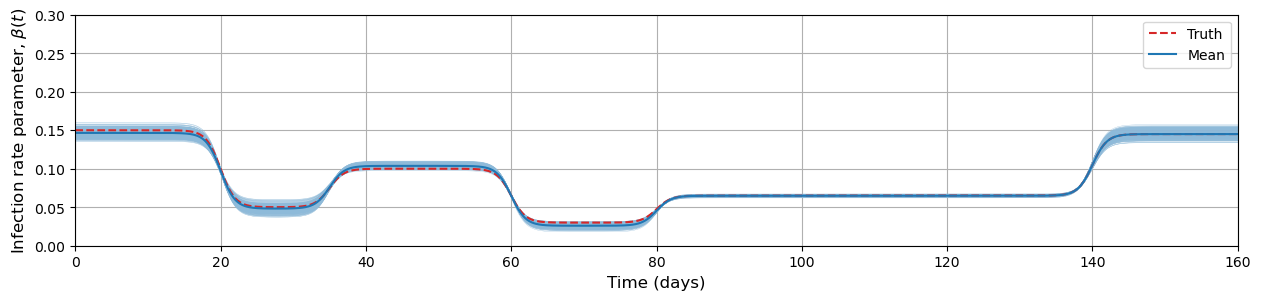

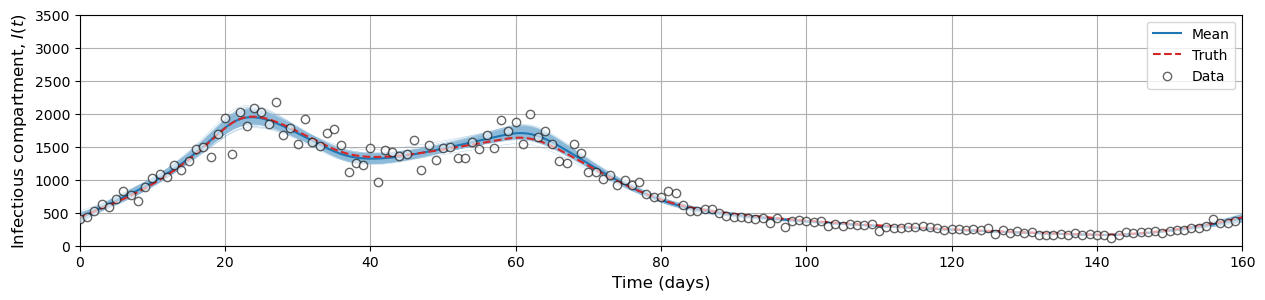

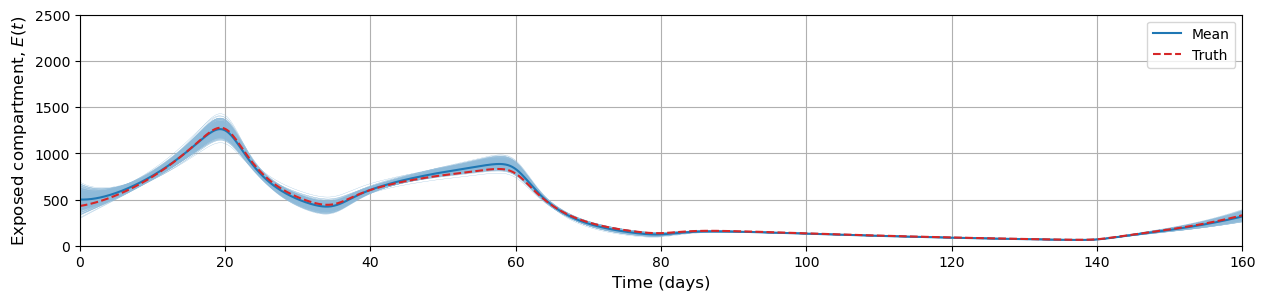

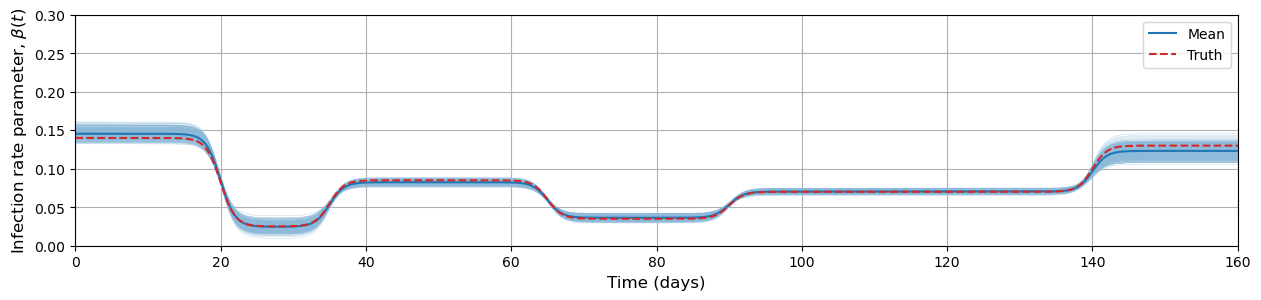

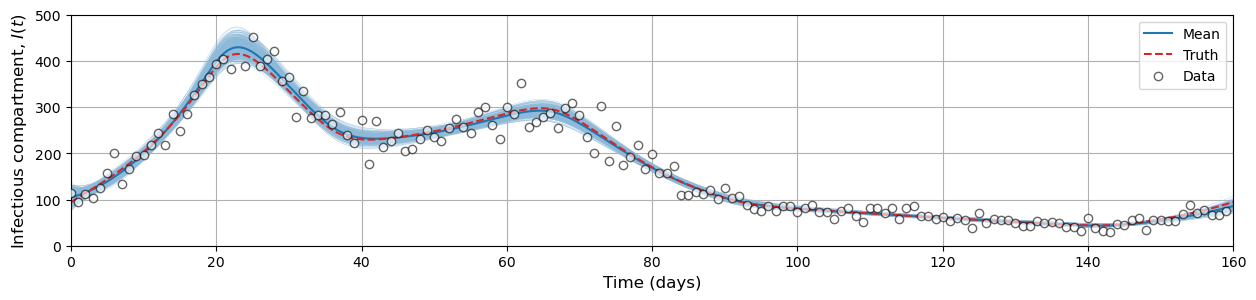

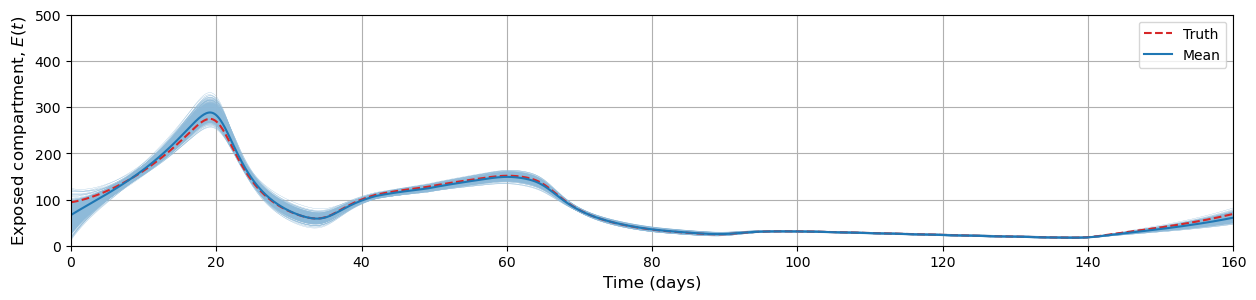

In [14]:
##### Printing beta samples

pred_low = int(tstart*ndiv)

pred_high = int(tlim*ndiv)

Nsamples = 500


for ns in range(Nsamples):

  ### Toronto
    # Initial Conditions
    ####### CHANGE HERE ######################
    E[0,0] = samples[0,ns]
    I[0,0] = samples[1,ns]
    #####################################

    R[0,0] = 0
    D[0,0] = 0
    N[0,0] = total[0]
    S[0,0] = N[0,0] - E[0,0] - I[0,0] - R[0,0] - D[0,0]

    a0 = samples[2,ns]
    a1 = samples[3,ns]
    t1 =  20
    a2 = samples[4,ns]
    t2 =  35
    a3 =  samples[5,ns]
    t3 = 60
    a4 =  samples[6,ns]
    t4 = 80
    a5 =  samples[7,ns]
    t5 =  140
    # a6 =  samples[8,ns]
    # t6 = 180
    # a7 =  samples[9,ns]
    # t7 =  190


    beta_i[:,0] = a0  + a1/(1 + np.exp((t1-tmoh))) +  a2/(1 + np.exp((t2-tmoh)))  + a3/(1 + np.exp((t3-tmoh)))  + a4/(1 + np.exp((t4-tmoh)))  + a5/(1 + np.exp((t5-tmoh))) \
        #   + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) 
    # + a8/(1 + np.exp((t8-tmoh)))

    beta_e[:,0] = beta_i[:,0]


    ##############################################################################################################    #####################################    #####################################

    ### Durham
    # Initial Conditions
    ####### CHANGE HERE ######################
    E[0,1] = samples[8,ns]
    I[0,1] = samples[9,ns]
    #####################################

    R[0,1] = 0
    D[0,1] = 0
    N[0,1] = total[1]
    S[0,1] = N[0,1] - E[0,1] - I[0,1] - R[0,1] - D[0,1]

    a0 = samples[10,ns]
    a1 = samples[11,ns]
    t1 =  20
    a2 = samples[12,ns]
    t2 =  35
    a3 =  samples[13,ns]
    t3 = 65
    a4 =  samples[14,ns]
    t4 = 90
    a5 =  samples[15,ns]
    t5 =  140
    # a6 =  samples[18,ns]
    # t6 = 180
    # a7 =  samples[19,ns]
    # t7 =  190


    beta_i[:,1] = a0  + a1/(1 + np.exp((t1-tmoh))) +  a2/(1 + np.exp((t2-tmoh)))  + a3/(1 + np.exp((t3-tmoh)))  + a4/(1 + np.exp((t4-tmoh)))  + a5/(1 + np.exp((t5-tmoh))) \
        #   + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) 
    # + a8/(1 + np.exp((t8-tmoh)))

    beta_e[:,1] = beta_i[:,1]

    if ns == 0:
        beta_append0=beta_e[:,0]
        beta_append1=beta_e[:,1]
    else:
        beta_append0=np.vstack((beta_append0,beta_e[:,0]))
        beta_append1=np.vstack((beta_append1,beta_e[:,1]))

    # ax1.plot(tmoh[pred_low:pred_high], beta_i[pred_low:pred_high,0], color=(142/255,186/255,217/255), linewidth=0.2, label='_nolegend_')


    idxmoh = 0

    for kk in range(1,len(tmoh)):

        for gg in range(0,N_city):

            L_sum = 0
            for ll in range(0,N_city):

                Nlm = 0
                L_cityinf = 0

                for mm in range(0,N_city):
                    Nlm =  Nlm + M[0,mm,ll,kk-1] * S[kk-1,mm] +  M[1,mm,ll,kk-1] * E[kk-1,mm] + M[2,mm,ll,kk-1] * I[kk-1,mm] + M[3,mm,ll,kk-1] * R[kk-1,mm]

                    L_cityinf = L_cityinf + (beta_e[kk-1,ll] * M[1,mm,ll,kk-1] * E[kk-1,mm] + beta_i[kk-1,ll] * M[2,mm,ll,kk-1] * I[kk-1,mm])


                L_sum = L_sum + (M[0,gg,ll,kk-1] * L_cityinf)/Nlm


            L_Force[kk-1,gg] = L_sum


            S[kk,gg] = S[kk-1,gg] - dt*(L_Force[kk-1,gg]*S[kk-1,gg])
            E[kk,gg] = E[kk-1,gg] + dt*(L_Force[kk-1,gg]*S[kk-1,gg] - (gamma_i + gamma_e)*E[kk-1,gg])
            I[kk,gg] = I[kk-1,gg] + dt*(gamma_i*E[kk-1,gg] - (gamma_r + gamma_d)*I[kk-1,gg])
            R[kk,gg] = R[kk-1,gg] + dt*(gamma_e*E[kk-1,gg] + gamma_r*I[kk-1,gg])
            D[kk,gg] = D[kk-1,gg] + dt*(gamma_d*I[kk-1,gg])
            N[kk,gg] = S[kk,gg] +  E[kk,gg] + I[kk,gg] + R[kk,gg]

    if ns == 0:
        s_append0=S[:,0]
        e_append0=E[:,0]
        i_append0=I[:,0]
        r_append0=R[:,0]
        d_append0=D[:,0]

        s_append1=S[:,1]
        e_append1=E[:,1]
        i_append1=I[:,1]
        r_append1=R[:,1]
        d_append1=D[:,1]
    else:
        s_append0=np.vstack((s_append0,S[:,0]))
        e_append0=np.vstack((e_append0,E[:,0]))
        i_append0=np.vstack((i_append0,I[:,0]))
        r_append0=np.vstack((r_append0,R[:,0]))
        d_append0=np.vstack((d_append0,D[:,0]))

        s_append1=np.vstack((s_append1,S[:,1]))
        e_append1=np.vstack((e_append1,E[:,1]))
        i_append1=np.vstack((i_append1,I[:,1]))
        r_append1=np.vstack((r_append1,R[:,1]))
        d_append1=np.vstack((d_append1,D[:,1]))

s_append0=s_append0.T
e_append0=e_append0.T
i_append0=i_append0.T
r_append0=r_append0.T
d_append0=d_append0.T

s_append1=s_append1.T
e_append1=e_append1.T
i_append1=i_append1.T
r_append1=r_append1.T
d_append1=d_append1.T

beta_append0=beta_append0.T
beta_append1=beta_append1.T


##########################################################################################
##########################################################################################
##########################################################################################

mpl.rcParams.update({'font.size':10})
fig1, ax1 = plt.subplots(figsize=(15, 3))
ax1.set_xlabel('Time (days)', fontsize=12)
ax1.set_ylabel(r'Infection rate parameter, $\beta(t)$', fontsize=12)
ax1.plot(tmoh[pred_low:pred_high], beta_append0[pred_low:pred_high,:], color=(142/255,186/255,217/255), linewidth=0.2, label='_nolegend_')
ax1.plot(tmoh[pred_low:pred_high], beta_truth[pred_low:pred_high,0], color='tab:red',linestyle='--', label='Truth')
ax1.plot(tmoh[pred_low:pred_high], beta_mean[pred_low:pred_high,0], color='tab:blue',linestyle='-', label='Mean')
ax1.legend()
ax1.grid()
plt.xlim([0,d_cut])
plt.ylim([0,0.3])
ax1.figure.savefig(f'{figpath}/beta_synthetic_uncertainty_toronto.pdf', bbox_inches='tight')
# ax1.figure.savefig(f'{figpath}/beta_real_uncertainty_case2.pdf', bbox_inches='tight')
plt.show()

fig2, ax2 = plt.subplots(figsize=(15, 3))
ax2.set_xlabel('Time (days)', fontsize=12)
ax2.set_ylabel(r'Infectious compartment, $I(t)$', fontsize=12)
ax2.plot(tmoh[pred_low:pred_high], i_append0[pred_low:pred_high,:], color=(142/255,186/255,217/255), linewidth=0.2, label='_nolegend_')
ax2.plot(tmoh[pred_low:pred_high], I_mean[pred_low:pred_high,0], color='tab:blue',linestyle='-', label='Mean')
ax2.plot(tmoh[pred_low:pred_high], all_truth0[pred_low:pred_high,2], color='tab:red',linestyle='--', label='Truth')
plt.scatter(t_data[0:d_cut],x_data[0:d_cut,0],color='w',edgecolors='k',zorder=3,alpha=0.6,label='Data')
ax2.legend()
ax2.grid()
plt.xlim([0,d_cut])
plt.ylim([0,3500])
ax2.figure.savefig(f'{figpath}/i_synthetic_uncertainty_toronto.pdf', bbox_inches='tight')
# ax2.figure.savefig(f'{figpath}/i_real_uncertainty_case2.pdf', bbox_inches='tight')
plt.show()

fig4, ax4 = plt.subplots(figsize=(15, 3))
ax4.set_xlabel('Time (days)', fontsize=12)
ax4.set_ylabel(r'Exposed compartment, $E(t)$', fontsize=12)
ax4.plot(tmoh[pred_low:pred_high], e_append0[pred_low:pred_high,:], color=(142/255,186/255,217/255), linewidth=0.2, label='_nolegend_')
ax4.plot(tmoh[pred_low:pred_high], E_mean[pred_low:pred_high,0], color='tab:blue',linestyle='-', label='Mean')
ax4.plot(tmoh[pred_low:pred_high], all_truth0[pred_low:pred_high,1], color='tab:red',linestyle='--', label='Truth')
ax4.legend()
ax4.grid()
plt.xlim([0,d_cut])
plt.ylim([0,2500])
# ax4.figure.savefig(f'{figpath}/e_synthetic_uncertainty.pdf', bbox_inches='tight')
ax4.figure.savefig(f'{figpath}/e_synthetic_uncertainty_toronto.pdf', bbox_inches='tight')
plt.show()



##########################################################################################
##########################################################################################
##########################################################################################


fig1, ax1 = plt.subplots(figsize=(15, 3))
ax1.set_xlabel('Time (days)', fontsize=12)
ax1.set_ylabel(r'Infection rate parameter, $\beta(t)$', fontsize=12)
ax1.plot(tmoh[pred_low:pred_high], beta_append1[pred_low:pred_high,:], color=(142/255,186/255,217/255), linewidth=0.2, label='_nolegend_')
ax1.plot(tmoh[pred_low:pred_high], beta_mean[pred_low:pred_high,1], color='tab:blue',linestyle='-', label='Mean')
ax1.plot(tmoh[pred_low:pred_high], beta_truth[pred_low:pred_high,1], color='tab:red',linestyle='--', label='Truth')
ax1.legend()
ax1.grid()
plt.xlim([0,d_cut])
plt.ylim([0.0,0.3])
ax1.figure.savefig(f'{figpath}/beta_synthetic_uncertainty_durham.pdf', bbox_inches='tight')
# ax1.figure.savefig(f'{figpath}/beta_real_uncertainty_case2.pdf', bbox_inches='tight')
plt.show()

fig2, ax2 = plt.subplots(figsize=(15, 3))
ax2.set_xlabel('Time (days)', fontsize=12)
ax2.set_ylabel(r'Infectious compartment, $I(t)$', fontsize=12)
ax2.plot(tmoh[pred_low:pred_high], i_append1[pred_low:pred_high,:], color=(142/255,186/255,217/255), linewidth=0.2, label='_nolegend_')
ax2.plot(tmoh[pred_low:pred_high], I_mean[pred_low:pred_high,1], color='tab:blue',linestyle='-', label='Mean')
ax2.plot(tmoh[pred_low:pred_high], all_truth1[pred_low:pred_high,2], color='tab:red',linestyle='--', label='Truth')
plt.scatter(t_data[0:d_cut],x_data[0:d_cut,1],color='w',edgecolors='k',zorder=3,alpha=0.6,label='Data')
ax2.legend()
ax2.grid()
plt.xlim([0,d_cut])
plt.ylim([0,500])
ax2.figure.savefig(f'{figpath}/i_synthetic_uncertainty_durham.pdf', bbox_inches='tight')
# ax2.figure.savefig(f'{figpath}/i_real_uncertainty_case2.pdf', bbox_inches='tight')
plt.show()

fig4, ax4 = plt.subplots(figsize=(15, 3))
ax4.set_xlabel('Time (days)', fontsize=12)
ax4.set_ylabel(r'Exposed compartment, $E(t)$', fontsize=12)
ax4.plot(tmoh[pred_low:pred_high], e_append1[pred_low:pred_high,:], color=(142/255,186/255,217/255), linewidth=0.2, label='_nolegend_')
ax4.plot(tmoh[pred_low:pred_high], all_truth1[pred_low:pred_high,1], color='tab:red',linestyle='--', label='Truth')
ax4.plot(tmoh[pred_low:pred_high], E_mean[pred_low:pred_high,1], color='tab:blue',linestyle='-', label='Mean')
ax4.legend()
ax4.grid()
plt.xlim([0,d_cut])
plt.ylim([0,500])
# ax4.figure.savefig(f'{figpath}/e_synthetic_uncertainty.pdf', bbox_inches='tight')
ax4.figure.savefig(f'{figpath}/e_synthetic_uncertainty_durham.pdf', bbox_inches='tight')
plt.show()


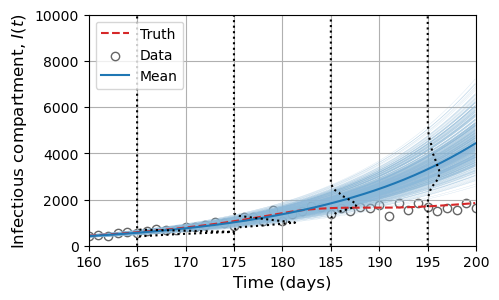

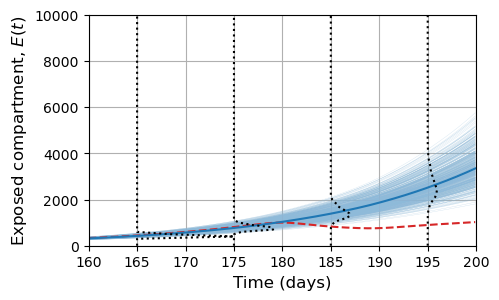

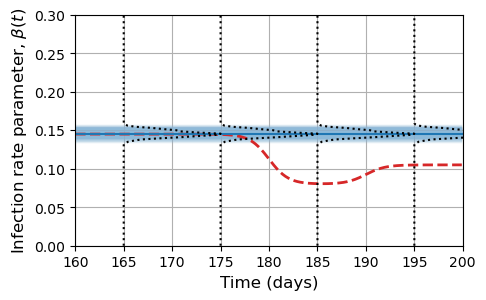

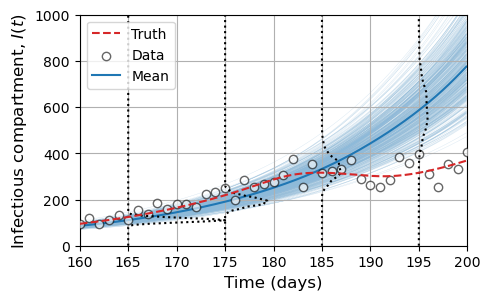

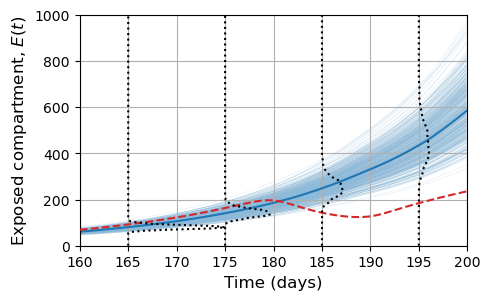

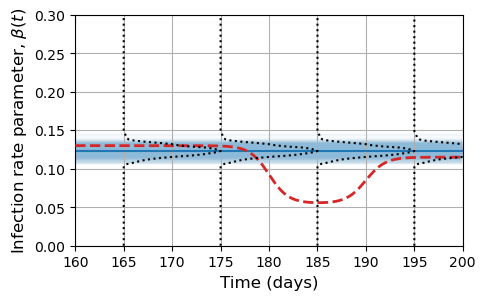

In [16]:
# d_cut = 160

pred_low = int(d_cut*ndiv)

pred_high = int(tlim*ndiv)

Nsamples = 500


for ns in range(Nsamples):

  ### Toronto
    # Initial Conditions
    ####### CHANGE HERE ######################
    E[0,0] = samples[0,ns]
    I[0,0] = samples[1,ns]
    #####################################

    R[0,0] = 0
    D[0,0] = 0
    N[0,0] = total[0]
    S[0,0] = N[0,0] - E[0,0] - I[0,0] - R[0,0] - D[0,0]

    a0 = samples[2,ns]
    a1 = samples[3,ns]
    t1 =  20
    a2 = samples[4,ns]
    t2 =  35
    a3 =  samples[5,ns]
    t3 = 60
    a4 =  samples[6,ns]
    t4 = 80
    a5 =  samples[7,ns]
    t5 =  140
    # a6 =  samples[8,ns]
    # t6 = 180
    # a7 =  samples[9,ns]
    # t7 =  190


    beta_i[:,0] = a0  + a1/(1 + np.exp((t1-tmoh))) +  a2/(1 + np.exp((t2-tmoh)))  + a3/(1 + np.exp((t3-tmoh)))  + a4/(1 + np.exp((t4-tmoh)))  + a5/(1 + np.exp((t5-tmoh))) \
        #   + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) 
    # + a8/(1 + np.exp((t8-tmoh)))

    beta_e[:,0] = beta_i[:,0]


    ##############################################################################################################    #####################################    #####################################

    ### Durham
    # Initial Conditions
    ####### CHANGE HERE ######################
    E[0,1] = samples[8,ns]
    I[0,1] = samples[9,ns]
    #####################################

    R[0,1] = 0
    D[0,1] = 0
    N[0,1] = total[1]
    S[0,1] = N[0,1] - E[0,1] - I[0,1] - R[0,1] - D[0,1]

    a0 = samples[10,ns]
    a1 = samples[11,ns]
    t1 =  20
    a2 = samples[12,ns]
    t2 =  35
    a3 =  samples[13,ns]
    t3 = 65
    a4 =  samples[14,ns]
    t4 = 90
    a5 =  samples[15,ns]
    t5 =  140
    # a6 =  samples[18,ns]
    # t6 = 180
    # a7 =  samples[19,ns]
    # t7 =  190


    beta_i[:,1] = a0  + a1/(1 + np.exp((t1-tmoh))) +  a2/(1 + np.exp((t2-tmoh)))  + a3/(1 + np.exp((t3-tmoh)))  + a4/(1 + np.exp((t4-tmoh)))  + a5/(1 + np.exp((t5-tmoh))) \
        #   + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) 
    # + a8/(1 + np.exp((t8-tmoh)))

    beta_e[:,1] = beta_i[:,1]

    if ns == 0:
        beta_append0=beta_e[:,0]
        beta_append1=beta_e[:,1]
    else:
        beta_append0=np.vstack((beta_append0,beta_e[:,0]))
        beta_append1=np.vstack((beta_append1,beta_e[:,1]))

    # ax1.plot(tmoh[pred_low:pred_high], beta_i[pred_low:pred_high,0], color=(142/255,186/255,217/255), linewidth=0.2, label='_nolegend_')


    idxmoh = 0

    for kk in range(1,len(tmoh)):

        for gg in range(0,N_city):

            L_sum = 0
            for ll in range(0,N_city):

                Nlm = 0
                L_cityinf = 0

                for mm in range(0,N_city):
                    Nlm =  Nlm + M[0,mm,ll,kk-1] * S[kk-1,mm] +  M[1,mm,ll,kk-1] * E[kk-1,mm] + M[2,mm,ll,kk-1] * I[kk-1,mm] + M[3,mm,ll,kk-1] * R[kk-1,mm]

                    L_cityinf = L_cityinf + (beta_e[kk-1,ll] * M[1,mm,ll,kk-1] * E[kk-1,mm] + beta_i[kk-1,ll] * M[2,mm,ll,kk-1] * I[kk-1,mm])


                L_sum = L_sum + (M[0,gg,ll,kk-1] * L_cityinf)/Nlm


            L_Force[kk-1,gg] = L_sum


            S[kk,gg] = S[kk-1,gg] - dt*(L_Force[kk-1,gg]*S[kk-1,gg])
            E[kk,gg] = E[kk-1,gg] + dt*(L_Force[kk-1,gg]*S[kk-1,gg] - (gamma_i + gamma_e)*E[kk-1,gg])
            I[kk,gg] = I[kk-1,gg] + dt*(gamma_i*E[kk-1,gg] - (gamma_r + gamma_d)*I[kk-1,gg])
            R[kk,gg] = R[kk-1,gg] + dt*(gamma_e*E[kk-1,gg] + gamma_r*I[kk-1,gg])
            D[kk,gg] = D[kk-1,gg] + dt*(gamma_d*I[kk-1,gg])
            N[kk,gg] = S[kk,gg] +  E[kk,gg] + I[kk,gg] + R[kk,gg]

    if ns == 0:
        s_append0=S[:,0]
        e_append0=E[:,0]
        i_append0=I[:,0]
        r_append0=R[:,0]
        d_append0=D[:,0]

        s_append1=S[:,1]
        e_append1=E[:,1]
        i_append1=I[:,1]
        r_append1=R[:,1]
        d_append1=D[:,1]
    else:
        s_append0=np.vstack((s_append0,S[:,0]))
        e_append0=np.vstack((e_append0,E[:,0]))
        i_append0=np.vstack((i_append0,I[:,0]))
        r_append0=np.vstack((r_append0,R[:,0]))
        d_append0=np.vstack((d_append0,D[:,0]))

        s_append1=np.vstack((s_append1,S[:,1]))
        e_append1=np.vstack((e_append1,E[:,1]))
        i_append1=np.vstack((i_append1,I[:,1]))
        r_append1=np.vstack((r_append1,R[:,1]))
        d_append1=np.vstack((d_append1,D[:,1]))

s_append0=s_append0.T
e_append0=e_append0.T
i_append0=i_append0.T
r_append0=r_append0.T
d_append0=d_append0.T

s_append1=s_append1.T
e_append1=e_append1.T
i_append1=i_append1.T
r_append1=r_append1.T
d_append1=d_append1.T

beta_append0=beta_append0.T
beta_append1=beta_append1.T

# print(np.shape(i_append[pred_low:pred_high,:]))
# print(np.shape(beta_append[pred_low:pred_high,:]))

Igrd = np.linspace(0,20000,201)
Ipdf_0 = st.gaussian_kde(i_append0[1650,:],bw_method = 0.2)
Ipdf_5 = st.gaussian_kde(i_append0[1750,:],bw_method = 0.2)
Ipdf_10 = st.gaussian_kde(i_append0[1850,:],bw_method = 0.2)
Ipdf_15 = st.gaussian_kde(i_append0[1950,:],bw_method = 0.2)
# Ipdf_20 = st.gaussian_kde(i_append[2000,:],bw_method = 0.2)
Imax = np.max([Ipdf_0(Igrd),Ipdf_5(Igrd),Ipdf_10(Igrd),Ipdf_15(Igrd)])
# Imax = np.max([Ipdf_0(Igrd),Ipdf_5(Igrd),Ipdf_10(Igrd),Ipdf_15(Igrd),Ipdf_20(Igrd)])


Egrd = np.linspace(0,20000,201)
Epdf_0 = st.gaussian_kde(e_append0[1650,:],bw_method = 0.2)
Epdf_5 = st.gaussian_kde(e_append0[1750,:],bw_method = 0.2)
Epdf_10 = st.gaussian_kde(e_append0[1850,:],bw_method = 0.2)
Epdf_15 = st.gaussian_kde(e_append0[1950,:],bw_method = 0.2)
# Ipdf_20 = st.gaussian_kde(i_append[2000,:],bw_method = 0.2)
Emax = np.max([Epdf_0(Egrd),Epdf_5(Egrd),Epdf_10(Egrd),Epdf_15(Egrd)])
# Imax = np.max([Ipdf_0(Igrd),Ipdf_5(Igrd),Ipdf_10(Igrd),Ipdf_15(Igrd),Ipdf_20(Igrd)])



Bgrd = np.linspace(0,0.3,201)
Bpdf_0 = st.gaussian_kde(beta_append0[1650,:],bw_method = 0.2)
Bpdf_5 = st.gaussian_kde(beta_append0[1750,:],bw_method = 0.2)
Bpdf_10 = st.gaussian_kde(beta_append0[1850,:],bw_method = 0.2)
Bpdf_15 = st.gaussian_kde(beta_append0[1950,:],bw_method = 0.2)
# Bpdf_20 = st.gaussian_kde(beta_append[2000,:],bw_method = 0.2)
Bmax = np.max([Bpdf_0(Igrd),Bpdf_5(Bgrd),Bpdf_10(Bgrd),Bpdf_15(Bgrd)])
# Bmax = np.max([Bpdf_0(Bgrd),Bpdf_5(Bgrd),Bpdf_10(Bgrd),Bpdf_15(Bgrd),Ipdf_20(Bgrd)])

t_data = np.arange(0,tlim+1)

f, ax = plt.subplots(1, figsize=(5,3))#15,3
plt.plot(tmoh[pred_low:pred_high], i_append0[pred_low:pred_high,:], color=(142/255,186/255,217/255,0.5), linewidth=0.2, label='_nolegend_')
plt.plot(tmoh[pred_low:pred_high], all_truth0[pred_low:pred_high,2], color='tab:red',linestyle='--', label='Truth')
plt.scatter(t_data[d_cut:tlim+1],x_data[d_cut:tlim+1,0],color='w',edgecolors='k',zorder=1,alpha=0.6,label='Data')
plt.plot(tmoh[pred_low:pred_high], I_mean[pred_low:pred_high,0], color='tab:blue',linestyle='-', label='Mean')
plt.grid(True)
plt.plot(165+Ipdf_0(Igrd)*10/Imax,Igrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(175+Ipdf_5(Igrd)*10/Imax,Igrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(185+Ipdf_10(Igrd)*10/Imax,Igrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(195+Ipdf_15(Igrd)*10/Imax,Igrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
# plt.plot(200+Ipdf_20(Igrd)*10/Imax,Igrd*2794356,linewidth=1.5,c='k',linestyle=':',zorder=3)
# plt.xticks([272, 279, 286,293,300])
plt.xlim([d_cut,tlim])
plt.ylim([0,1e4])
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel(r'Infectious compartment, $I(t)$', fontsize=12)
ax.legend(loc='upper left')
# ax.legend(loc='upper left', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=3, fontsize=12)
plt.savefig(f'{figpath}/forecast_i_synth_toronto.pdf',bbox_inches='tight')



f, ax = plt.subplots(1, figsize=(5,3))#15,3
plt.plot(tmoh[pred_low:pred_high], e_append0[pred_low:pred_high,:], color=(142/255,186/255,217/255,0.5), linewidth=0.2, label='_nolegend_')
plt.plot(tmoh[pred_low:pred_high], all_truth0[pred_low:pred_high,1], color='tab:red',linestyle='--', label='Truth')
plt.plot(tmoh[pred_low:pred_high], E_mean[pred_low:pred_high,0], color='tab:blue',linestyle='-', label='Mean')
plt.grid(True)
plt.plot(165+Epdf_0(Egrd)*10/Emax,Egrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(175+Epdf_5(Egrd)*10/Emax,Egrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(185+Epdf_10(Egrd)*10/Emax,Egrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(195+Epdf_15(Egrd)*10/Emax,Egrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
# plt.plot(200+Ipdf_20(Igrd)*10/Imax,Igrd*2794356,linewidth=1.5,c='k',linestyle=':',zorder=3)
# plt.xticks([272, 279, 286,293,300])
plt.xlim([d_cut,tlim])
plt.ylim([0,1e4])
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel(r'Exposed compartment, $E(t)$', fontsize=12)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=3, fontsize=12)
plt.savefig(f'{figpath}/forecast_e_synth_toronto.pdf',bbox_inches='tight')


f, ax = plt.subplots(1, figsize=(5,3))#15,3
plt.plot(tmoh[pred_low:pred_high], beta_append0[pred_low:pred_high,:], color=(142/255,186/255,217/255,0.5), linewidth=0.2, label='_nolegend_')
plt.plot(tmoh[pred_low:pred_high], beta_truth[pred_low:pred_high,0],linewidth=2,c='tab:red',linestyle='--', label='Truth')
plt.plot(tmoh[pred_low:pred_high], beta_mean[pred_low:pred_high,0], color='tab:blue',linestyle='-', label='Mean')
plt.grid(True)
# plt.xticks([272, 279, 286,293,300])
plt.plot(165+Bpdf_0(Bgrd)*10/Bmax,Bgrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(175+Bpdf_5(Bgrd)*10/Bmax,Bgrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(185+Bpdf_10(Bgrd)*10/Bmax,Bgrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(195+Bpdf_15(Bgrd)*10/Bmax,Bgrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
# plt.plot(200+Bpdf_20(Bgrd)*10/Bmax,Bgrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.xlim([d_cut,tlim])
plt.ylim([0,0.3])
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel(r'Infection rate parameter, $\beta(t)$', fontsize=12)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=3, fontsize=12)
plt.savefig(f'{figpath}/forecast_beta_synth_toronto.pdf',bbox_inches='tight')






##########################################################################################
##########################################################################################
##########################################################################################
######### DURHAM ###########

##########################################################################################
##########################################################################################
##########################################################################################


Igrd = np.linspace(0,1000,201)
Ipdf_0 = st.gaussian_kde(i_append1[1650,:],bw_method = 0.2)
Ipdf_5 = st.gaussian_kde(i_append1[1750,:],bw_method = 0.2)
Ipdf_10 = st.gaussian_kde(i_append1[1850,:],bw_method = 0.2)
Ipdf_15 = st.gaussian_kde(i_append1[1950,:],bw_method = 0.2)
# Ipdf_20 = st.gaussian_kde(i_append[2000,:],bw_method = 0.2)
Imax = np.max([Ipdf_0(Igrd),Ipdf_5(Igrd),Ipdf_10(Igrd),Ipdf_15(Igrd)])
# Imax = np.max([Ipdf_0(Igrd),Ipdf_5(Igrd),Ipdf_10(Igrd),Ipdf_15(Igrd),Ipdf_20(Igrd)])


Egrd = np.linspace(0,1000,201)
Epdf_0 = st.gaussian_kde(e_append1[1650,:],bw_method = 0.2)
Epdf_5 = st.gaussian_kde(e_append1[1750,:],bw_method = 0.2)
Epdf_10 = st.gaussian_kde(e_append1[1850,:],bw_method = 0.2)
Epdf_15 = st.gaussian_kde(e_append1[1950,:],bw_method = 0.2)
# Ipdf_20 = st.gaussian_kde(i_append[2000,:],bw_method = 0.2)
Emax = np.max([Epdf_0(Egrd),Epdf_5(Egrd),Epdf_10(Egrd),Epdf_15(Egrd)])
# Imax = np.max([Ipdf_0(Igrd),Ipdf_5(Igrd),Ipdf_10(Igrd),Ipdf_15(Igrd),Ipdf_20(Igrd)])



Bgrd = np.linspace(0,0.3,201)
Bpdf_0 = st.gaussian_kde(beta_append1[1650,:],bw_method = 0.2)
Bpdf_5 = st.gaussian_kde(beta_append1[1750,:],bw_method = 0.2)
Bpdf_10 = st.gaussian_kde(beta_append1[1850,:],bw_method = 0.2)
Bpdf_15 = st.gaussian_kde(beta_append1[1950,:],bw_method = 0.2)
# Bpdf_20 = st.gaussian_kde(beta_append[2000,:],bw_method = 0.2)
Bmax = np.max([Bpdf_0(Igrd),Bpdf_5(Bgrd),Bpdf_10(Bgrd),Bpdf_15(Bgrd)])
# Bmax = np.max([Bpdf_0(Bgrd),Bpdf_5(Bgrd),Bpdf_10(Bgrd),Bpdf_15(Bgrd),Ipdf_20(Bgrd)])


f, ax = plt.subplots(1, figsize=(5,3))#15,3
plt.plot(tmoh[pred_low:pred_high], i_append1[pred_low:pred_high,:], color=(142/255,186/255,217/255,0.5), linewidth=0.2, zorder=1,  label='_nolegend_')
plt.plot(tmoh[pred_low:pred_high], all_truth1[pred_low:pred_high,2], color='tab:red',linestyle='--', zorder=4, label='Truth')
plt.scatter(t_data[d_cut:tlim+1],x_data[d_cut:tlim+1,1],color='w',edgecolors='k',zorder=3,alpha=0.6,label='Data')
plt.plot(tmoh[pred_low:pred_high], I_mean[pred_low:pred_high,1], color='tab:blue',linestyle='-', zorder=2, label='Mean')
plt.grid(True)
plt.plot(165+Ipdf_0(Igrd)*10/Imax,Igrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(175+Ipdf_5(Igrd)*10/Imax,Igrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(185+Ipdf_10(Igrd)*10/Imax,Igrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(195+Ipdf_15(Igrd)*10/Imax,Igrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
# plt.plot(200+Ipdf_20(Igrd)*10/Imax,Igrd*2794356,linewidth=1.5,c='k',linestyle=':',zorder=3)
# plt.xticks([272, 279, 286,293,300])
plt.xlim([d_cut,tlim])
plt.ylim([0,1000])
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel(r'Infectious compartment, $I(t)$', fontsize=12)
ax.legend(loc='upper left')
# ax.legend(loc='upper left', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=3, fontsize=12)
plt.savefig(f'{figpath}/forecast_i_synth_durham.pdf',bbox_inches='tight')



f, ax = plt.subplots(1, figsize=(5,3))#15,3
plt.plot(tmoh[pred_low:pred_high], e_append1[pred_low:pred_high,:], color=(142/255,186/255,217/255,0.5), linewidth=0.2, zorder=1, label='_nolegend_')
plt.plot(tmoh[pred_low:pred_high], all_truth1[pred_low:pred_high,1], color='tab:red',linestyle='--',  zorder=3, label='Truth')
plt.plot(tmoh[pred_low:pred_high], E_mean[pred_low:pred_high,1], color='tab:blue',linestyle='-',  zorder=2, label='Mean')
plt.grid(True)
plt.plot(165+Epdf_0(Egrd)*10/Emax,Egrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(175+Epdf_5(Egrd)*10/Emax,Egrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(185+Epdf_10(Egrd)*10/Emax,Egrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(195+Epdf_15(Egrd)*10/Emax,Egrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
# plt.plot(200+Ipdf_20(Igrd)*10/Imax,Igrd*2794356,linewidth=1.5,c='k',linestyle=':',zorder=3)
# plt.xticks([272, 279, 286,293,300])
plt.xlim([d_cut,tlim])
plt.ylim([0,1000])
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel(r'Exposed compartment, $E(t)$', fontsize=12)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=3, fontsize=12)
plt.savefig(f'{figpath}/forecast_e_synth_durham.pdf',bbox_inches='tight')


f, ax = plt.subplots(1, figsize=(5,3))#15,3
plt.plot(tmoh[pred_low:pred_high], beta_append1[pred_low:pred_high,:], color=(142/255,186/255,217/255,0.5), linewidth=0.2,  zorder=1, label='_nolegend_')
plt.plot(tmoh[pred_low:pred_high], beta_truth[pred_low:pred_high,1],linewidth=2,c='tab:red',linestyle='--',  zorder=3, label='Truth')
plt.plot(tmoh[pred_low:pred_high], beta_mean[pred_low:pred_high,1], color='tab:blue',linestyle='-', zorder=2,  label='Mean')
plt.grid(True)
# plt.xticks([272, 279, 286,293,300])
plt.plot(165+Bpdf_0(Bgrd)*10/Bmax,Bgrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(175+Bpdf_5(Bgrd)*10/Bmax,Bgrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(185+Bpdf_10(Bgrd)*10/Bmax,Bgrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.plot(195+Bpdf_15(Bgrd)*10/Bmax,Bgrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
# plt.plot(200+Bpdf_20(Bgrd)*10/Bmax,Bgrd,linewidth=1.5,c='k',linestyle=':',zorder=3)
plt.xlim([d_cut,tlim])
plt.ylim([0,0.3])
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel(r'Infection rate parameter, $\beta(t)$', fontsize=12)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=3, fontsize=12)
plt.savefig(f'{figpath}/forecast_beta_synth_durham.pdf',bbox_inches='tight')


In [ ]:
# ###### Plotting PDFS ##########

# from scipy.stats import gaussian_kde

# x1 = np.linspace(0,1000, 100)

# kde = gaussian_kde(I_pdf[0,:], bw_method='scott')

# kde_t1 = kde(x1)

# fig,ax = plt.subplots(figsize=(6, 4))
# plt.plot(x1,kde_t1,label = '160 days')
# plt.xlabel('$I$')
# plt.ylabel('$p(I)$')
# plt.autoscale(enable=True, axis='x', tight=True)
# plt.legend()
# plt.savefig(f'{figpath}/pdf_0.pdf',bbox_inches='tight' )
# plt.show()


# x2 = np.linspace(0,3000, 100)

# kde = gaussian_kde(I_pdf[9,:], bw_method='scott')

# kde_t2 = kde(x2)

# fig,ax = plt.subplots(figsize=(6, 4))
# plt.plot(x2,kde_t2,label = '170 days')
# plt.xlabel('$I$')
# plt.ylabel('$p(I)$')
# plt.autoscale(enable=True, axis='x', tight=True)
# plt.legend()
# plt.savefig(f'{figpath}/pdf_10.pdf', bbox_inches='tight')
# plt.show()



# x3 = np.linspace(0,5000, 100)

# kde = gaussian_kde(I_pdf[19,:], bw_method='scott')

# kde_t3 = kde(x3)

# fig,ax = plt.subplots(figsize=(6, 4))
# plt.plot(x3,kde_t3,label = '180 days')
# plt.xlabel('$I$')
# plt.ylabel('$p(I)$')
# plt.autoscale(enable=True, axis='x', tight=True)
# plt.legend()
# plt.savefig(f'{figpath}/pdf_20.pdf', bbox_inches='tight')
# plt.show()




# x4 = np.linspace(0,10000, 100)

# kde = gaussian_kde(I_pdf[29,:], bw_method='scott')

# kde_t4 = kde(x4)

# fig,ax = plt.subplots(figsize=(6, 4))
# plt.plot(x4,kde_t4,label = '190 days')
# plt.xlabel('$I$')
# plt.ylabel('$p(I)$')
# plt.autoscale(enable=True, axis='x', tight=True)
# plt.legend()
# plt.savefig(f'{figpath}/pdf_30.pdf', bbox_inches='tight')
# plt.show()




In [ ]:
## Model Full
skip = 2

# samples = np.loadtxt('../../data/muVec_synth_noise10_initial.dat')
# samples = np.loadtxt('../../data/muVec_real.dat')
label = [r'$E_0$', r'$I_0$', r'$a_0$',r'$a_1$',r'$a_2$',r'$a_3$',r'$a_4$',r'$a_5$',r'$a_6$',r'$a_7$']
Npar = len(samples[:,0])
# true = [500, 380, 0.15,-0.1,0.05,-0.07,0.035,0.08, ]

### For real data
true = [500, 380, 0.146,-0.09,0.05,-0.06,0.020,0.085,-0.05, -0.01]


find_map = 1
if find_map == 1:
  from scipy.optimize import minimize
  kde = st.gaussian_kde(samples)
  def kde_fun(x):
    return -kde(x)
  res = minimize(kde_fun,true, method='nelder-mead',options={'xatol': 1e-8, 'disp': True})
  # print(res.x)
  maps = res.x
  # np.savetxt('chains/ModelSIRS_SIS-map.dat',maps)

for ii in range(len(samples[:,0])):
  xmin,xmax = np.min(samples[ii,:]), np.max(samples[ii,:])
  # if param_true[ii] < xmin:
  #   xmin = param_true[ii]
  # elif  param_true[ii] > xmax:
  #   xmax = param_true[ii]

  print(np.mean(samples[ii,:]),np.std(samples[ii,:]),maps[ii])

  xmean = (xmin + xmax)/2
  xrang = (xmax - xmin)
  x_low = np.max([xmean-0.55*xrang])
  x_up = np.min([xmean+0.55*xrang])

  f, ax = plt.subplots(1, figsize=(3,3))
  Xpdf = st.gaussian_kde(samples[ii,:],bw_method = 0.2)
  # print(Xpdf.silverman_factor())
  # Xgrd = np.linspace(np.min(samples[ii,:]),np.max(samples[ii,:]))
  Xgrd = np.linspace(x_low,x_up,201)
  pdfmax = max(Xpdf(Xgrd))
  plt.plot(Xgrd,Xpdf(Xgrd),color='tab:blue',linewidth=2)
  plt.hist(samples[ii,:],bins=50,density=True,alpha=0.25)

  ### Uncomment for Synthetic data
#   plt.plot([true[ii],true[ii]],[0,1.1*pdfmax],c='tab:red',linewidth=2,linestyle='--')
  plt.plot([maps[ii],maps[ii]],[0,1.1*pdfmax],c='tab:green',linewidth=2,linestyle=':')
  myYlim = [0.0, 1.1*pdfmax]
  plt.ylabel('pdf', fontsize=12)
  plt.xlabel(label[ii], fontsize=12)
  plt.ylim(myYlim)
  plt.xlim([x_low,x_up])
  plt.yticks([])
  plt.grid(True)
  plt.savefig(f'{figpath}/real_toronto_mpdf_'+ str(ii)+'.pdf',bbox_inches='tight')
  # plt.close()

  for jj in range(Npar):
   if ii != jj:
      ymin,ymax = np.min(samples[jj,:]), np.max(samples[jj,:])
      ymean = (ymin + ymax)/2
      yrang = (ymax - ymin)
      y_low = np.max([ymean-0.55*yrang])
      y_up = np.min([ymean+0.55*yrang])

      f, ax = plt.subplots(1, figsize=(3,3))
      plt.scatter(samples[ii,::skip],samples[jj,::skip],alpha=0.1,s=25)
      plt.plot([x_low,x_up],[maps[jj],maps[jj]],c='tab:green',linewidth=2,linestyle=':')
    #   plt.plot([x_low,x_up],[true[jj],true[jj]],c='tab:red',linewidth=2,linestyle='--')
    #   plt.plot([true[ii],true[ii]],[y_low,y_up],c='tab:red',linewidth=2,linestyle='--')
      plt.plot([maps[ii],maps[ii]],[y_low,y_up],c='tab:green',linewidth=2,linestyle=':')
      plt.xlim([x_low,x_up])
      plt.ylim([y_low,y_up])
      plt.xlabel(label[ii],fontsize=12)
      plt.ylabel(label[jj],fontsize=12)
      plt.savefig(f'{figpath}/real_toronto_jpdf_'+ str(ii)+str(jj)+'.pdf',bbox_inches='tight')
      # plt.close()